[View in Colaboratory](https://colab.research.google.com/github/nikhilno1/100DaysOfMLCode/blob/master/DNST_CIFAR10.ipynb)

In [0]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import toimage
import time


In [0]:
# this part will prevent tensorflow to allocate all the available GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
!rm -rf clr_callback.py*
!wget https://github.com/bckenstler/CLR/raw/master/clr_callback.py
from clr_callback import *

--2018-10-19 08:17:40--  https://github.com/bckenstler/CLR/raw/master/clr_callback.py
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py [following]
--2018-10-19 08:17:40--  https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5326 (5.2K) [text/plain]
Saving to: ‘clr_callback.py’

clr_callback.py     100%[===================>]   5.20K  --.-KB/s    in 0s      

2018-10-19 08:17:40 (48.8 MB/s) - ‘clr_callback.py’ saved [5326/5326]



In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 250
l = 12
nb_filter = 24
compression = 0.9
dropout_rate = 0.0
growth_rate = 12

In [0]:
def lr_schedule(epoch):
    #lrate = 0.001
    lrate = 0.01
    if epoch > 75:
        #lrate = 0.0005
        lrate = 0.001
    elif epoch > 150:
        #lrate = 0.0003
        lrate = 0.0001
    return lrate

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression, growth_rate, nb_filter
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(growth_rate, (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        nb_filter += growth_rate
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter * compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    #AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    GlobalAvg = GlobalAveragePooling2D()(relu)
    #flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(GlobalAvg)
    
    return output

In [0]:
#num_filter = 24
#dropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(nb_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, nb_filter, dropout_rate)
First_Transition = add_transition(First_Block, nb_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, nb_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, nb_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, nb_filter, dropout_rate)
#Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

output = output_layer(Third_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#model.load_weights("/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_aug.best.h5")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [0]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [0]:
lr_reducer      = ReduceLROnPlateau(monitor='val_acc', factor=np.sqrt(0.1),
                                    cooldown=0, patience=5, min_lr=1e-5)

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
# run_type = "RunX_IMG_AUG_LR_SCH"
# epoch_set = 10
# for ep in range(1,26):
#   print('Running iteration: ' + str(ep))
#   #model.fit(x_train, y_train,
#   #                  batch_size=batch_size,
#   #                  epochs=epoch_set,
#   #                  verbose=1,
#   #                  validation_data=(x_test, y_test))
#   #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
#   #                  steps_per_epoch=x_train.shape[0] // batch_size,epochs=epoch_set,\
#   #                  verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])  
#   path = "/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/DNST_model_" + run_type + "_" + str((ep * epoch_set))
#   model.save_weights(path)
#   model_json = model.to_json()
#   json_path = path + ".json"
#   with open(json_path, 'w') as json_file:
#     json_file.write(model_json)


In [0]:
# checkpoint
filepath="/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#clr_triangular = CyclicLR(mode='triangular2')
#clr_triangular = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')
callbacks_list = [checkpoint, lr_reducer]
#callbacks_list = [checkpoint, LearningRateScheduler(lr_schedule)]
#callbacks_list = [checkpoint, clr_triangular]



In [0]:
#epochs=155

In [0]:
start = time.time()
model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1, validation_data=(x_test,y_test),\
                    callbacks=callbacks_list) 
end = time.time()


Epoch 1/250
781/781 [==============================] - 283s 362ms/step - loss: 1.4007 - acc: 0.4924 - val_loss: 1.5455 - val_acc: 0.4917

Epoch 00001: val_acc improved from -inf to 0.49170, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch.best.h5
Epoch 2/250
781/781 [==============================] - 270s 346ms/step - loss: 0.9953 - acc: 0.6457 - val_loss: 1.1008 - val_acc: 0.6185

Epoch 00002: val_acc improved from 0.49170 to 0.61850, saving model to /content/gdrive/My Drive/Model Weights/DNST_CIFAR10/weights_with_lrsch.best.h5
Epoch 3/250
781/781 [==============================] - 271s 347ms/step - loss: 0.8350 - acc: 0.7047 - val_loss: 2.5236 - val_acc: 0.4152

Epoch 00003: val_acc did not improve from 0.61850
Epoch 4/250
781/781 [==============================] - 271s 347ms/step - loss: 0.7295 - acc: 0.7467 - val_loss: 1.1593 - val_acc: 0.6473

Epoch 00004: val_acc improved from 0.61850 to 0.64730, saving model to /content/gdrive/My Drive/Model

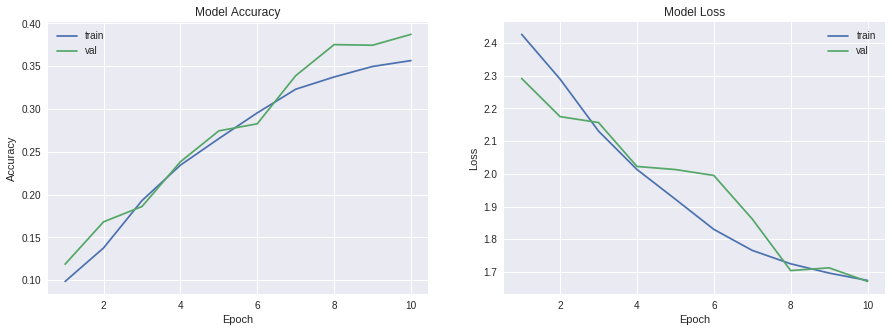

Model took 1137.36 seconds to train
Accuracy on test data is: 38.73


In [0]:
# plot model history
plot_model_history(model_info)
print("Model took %0.2f seconds to train" % (end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f" % accuracy(x_test, y_test, model))

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 11s 1ms/step
Test loss: 1.6708751831054687
Test accuracy: 0.3873


In [0]:
# # Save the trained weights in to .h5 format
# model.save_weights("DNST_model.h5")
# print("Saved model to disk")

In [0]:
# from google.colab import files

# files.download('DNST_model.h5')

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# with open('/content/gdrive/My Drive/Model Weights/DNST_CIFAR10/foo.txt', 'w') as f:
#   f.write('Hello Google Drive!')
# !cat /content/gdrive/My\ Drive/foo.txt

In [0]:
from keras.datasets import cifar10 
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])

NameError: ignored